In [20]:
!pip install aesara > /dev/null
!pip install pymc > /dev/null
!pip install arviz > /dev/null
!pip install statsmodels > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.12.0 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [21]:
!pip install --upgrade --force-reinstall numpy scipy scikit-learn > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aesara 2.9.4 requires numpy<2.0.0,>=1.17.0, but you have numpy 2.3.1 which is incompatible.
aesara 2.9.4 requires scipy<=1.12.0,>=0.14, but you have scipy 1.16.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
plotnine 0.14.6 requires scipy<1.16.0,>=1.8.0, but you have scipy 1.16.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import arviz as az

import pymc as pm
import pytensor.tensor as at

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [44]:
def rbf_kernel_matrix(X, h):
    N, D = X.shape
    pairwise_dists = np.sum((X[:, None, :] - X[None, :, :])**2, axis=2)
    K = np.exp(-pairwise_dists / (2 * h**2))
    grad_K = -(X[:, None, :] - X[None, :, :]) * K[:, :, None] / (h**2)
    return K, grad_K

In [45]:
def median_bandwidth(X):
    pairwise_dists = np.sum((X[:, None, :] - X[None, :, :])**2, axis=2)
    median_sq = np.median(pairwise_dists)
    h = np.sqrt(0.5 * median_sq / np.log(X.shape[0] + 1e-6))
    return h


In [46]:
def svgd_step(particles, log_prob_fn, h, stepsize=0.1):
    N, D = particles.shape
    eps = 1e-4
    score = np.zeros_like(particles)
    for i in range(D):
        shift = np.zeros(D)
        shift[i] = eps
        forward = log_prob_fn(particles + shift[None, :])
        backward = log_prob_fn(particles - shift[None, :])
        score[:, i] = (forward - backward) / (2 * eps)

    K, grad_K = rbf_kernel_matrix(particles, h)
    phi = (K @ score) / N + np.sum(grad_K, axis=1) / N
    particles += stepsize * phi
    return particles


In [47]:
def run_svgd(particles_init, log_prob_fn, n_iter, stepsize=0.1, adapt_every=None):
    particles = particles_init.copy()
    history = []

    h = median_bandwidth(particles)
    print(f"Initial bandwidth: {h:.3f}")

    for it in range(n_iter):
        if adapt_every is not None and it % adapt_every == 0:
            h = median_bandwidth(particles)

        particles = svgd_step(particles, log_prob_fn, h, stepsize)

        if it % 50 == 0 or it == n_iter - 1:
            print(f"Iteration {it}")
            history.append(particles.copy())

    return history


In [48]:
def banana_log_prob(x, b=0.1):
    """
    Banana-shaped log density:
    x: [N, 2] array of particles
    b: banana parameter
    """
    x1 = x[:, 0]
    x2 = x[:, 1]
    term1 = -0.5 * (x1 / 2.0)**2
    term2 = -0.5 * ((x2 - b * x1**2 + 100 * b)**2 / 2.0)
    return term1 + term2

In [49]:
np.random.seed(42)
num_particles = 200
particles_init = np.random.randn(num_particles, 2) * 5.0

num_iterations = 500
stepsize = 0.1

print("Running fixed bandwidth SVGD")
fixed_history = run_svgd(particles_init, banana_log_prob, num_iterations, stepsize, adapt_every=None)

print("\nRunning adaptive bandwidth SVGD")
adaptive_history = run_svgd(particles_init, banana_log_prob, num_iterations, stepsize, adapt_every=10)


Running fixed bandwidth SVGD
Initial bandwidth: 2.422
Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 499

Running adaptive bandwidth SVGD
Initial bandwidth: 2.422
Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 499


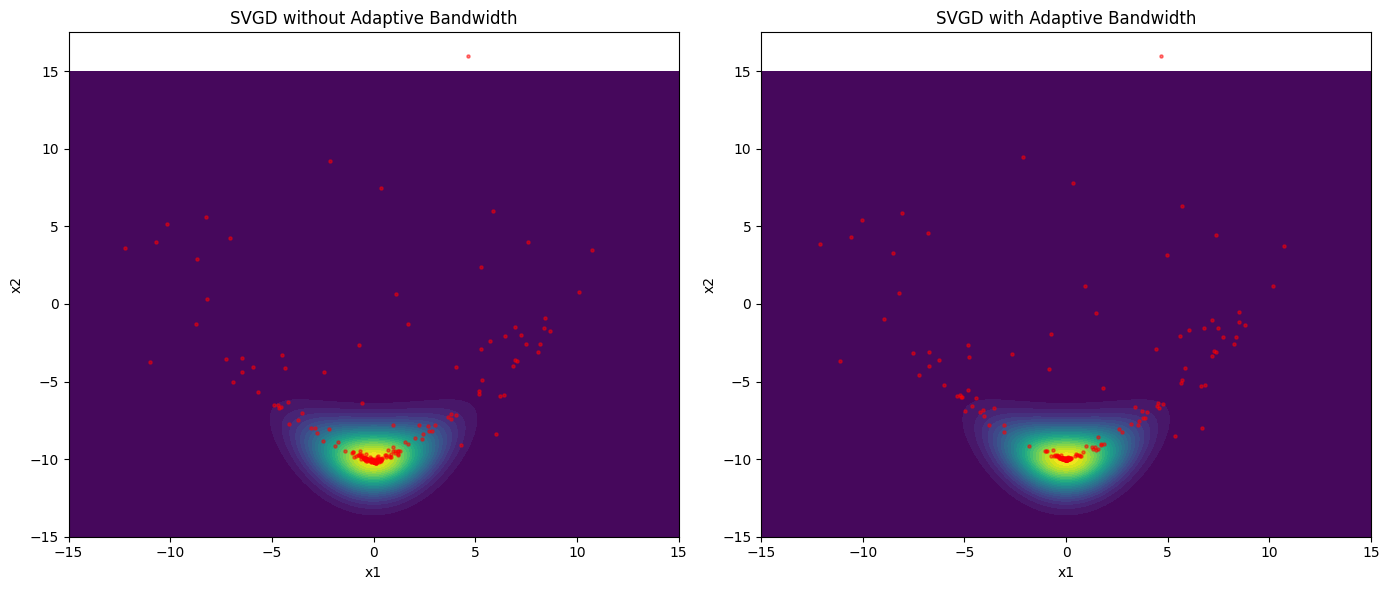

In [50]:
levels = 30
X_grid, Y_grid = np.meshgrid(np.linspace(-15, 15, 200), np.linspace(-15, 15, 200))
points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T
Z = np.exp(banana_log_prob(points)).reshape(X_grid.shape)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].contourf(X_grid, Y_grid, Z, levels=levels, cmap='viridis')
axs[0].scatter(fixed_history[-1][:, 0], fixed_history[-1][:, 1], s=5, color='red', alpha=0.5)
axs[0].set_title('SVGD without Adaptive Bandwidth')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].contourf(X_grid, Y_grid, Z, levels=levels, cmap='viridis')
axs[1].scatter(adaptive_history[-1][:, 0], adaptive_history[-1][:, 1], s=5, color='red', alpha=0.5)
axs[1].set_title('SVGD with Adaptive Bandwidth')
axs[1].set_xlabel('x1')
axs[1].set_ylabel('x2')

plt.tight_layout()
plt.show()
